In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
import re
from copy import deepcopy
flatten = lambda l: [item for sublist in l for item in sublist]

import matplotlib.pyplot as plt
import itertools
import pandas as pd

#random.seed(1024)
%matplotlib inline

In [2]:
USE_CUDA = torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [3]:
def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [4]:
def pad_to_batch(batch):
    x,y = zip(*batch)
    max_x = max([s.size(1) for s in x])
    x_p = []
    for i in range(len(batch)):
        if x[i].size(1) < max_x:
            x_p.append(torch.cat([x[i], Variable(LongTensor([word2index['<PAD>']] * (max_x - x[i].size(1)))).view(1, -1)], 1))
        else:
            x_p.append(x[i])
    return torch.cat(x_p), torch.cat(y).view(-1)

In [5]:
def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

## Data Loading and Pre-processing

In [6]:
inspire_data = pd.read_pickle('data/INSPIREpy2.df')

inspire_data = inspire_data.reindex(np.random.permutation(inspire_data.index))
inspire_data = inspire_data.reset_index(drop=True)

training_samples = 3 * len(inspire_data) // 5
validation_samples = len(inspire_data) // 5

In [7]:
X = list(inspire_data['texts'])
y = list(inspire_data['coreness'])

In [8]:
# Get the class weights
rejected_count = y.count(0)
noncore_count = y.count(1)
core_count = y.count(2)

total_count = len(y)

inverse_rejected_fraction = total_count / rejected_count
inverse_noncore_fraction = total_count / noncore_count
inverse_core_fraction = total_count / core_count 

sum_fractions = inverse_rejected_fraction + inverse_noncore_fraction + inverse_core_fraction

# Specify the class weights (for the loss function specified later)
class_weights = torch.cuda.FloatTensor((inverse_rejected_fraction/sum_fractions,
                                        inverse_noncore_fraction/sum_fractions,
                                        inverse_core_fraction/sum_fractions))

In [9]:
class_weights = class_weights / class_weights[1]
print(class_weights)

tensor([ 0.1002,  1.0000,  0.5850], device='cuda:0')


#### Lowercase all text

In [10]:
# Lowercase the entire text corpora
X = [x.lower() for x in X]

#### Remove punctuation

In [11]:
punc_to_remove = str('!"%&\'()*+,./:;<=>?@[\\]^_`{|}~')
for i, x in enumerate(X):
    X[i] = ' '.join(word.strip(punc_to_remove) for word in x.split())

#### Num Masking

In [12]:
for i, x in enumerate(X):
    X[i] = re.sub('\d+', '<NUM>', x)

#### Replace Latex Equations

In [13]:
for i, _ in enumerate(X):
    f = re.search(r"(.+(?P<name>\$.+\$).+)+", X[i])
    while f is not None:
        X[i] = re.sub(re.escape(f.group('name')), '<FORMULA>', X[i])
        f = re.search(r"(.+(?P<name>\$.+\$).+)+", X[i])

#### Tokenize the text

In [14]:
X = [nltk.word_tokenize(x) for x in X]

#### Lemmatize the text

In [15]:
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
X = [[wordnet_lemmatizer.lemmatize(word) for word in x] for x in X]

#### Build vocabulary

In [16]:
vocab = list(set(flatten(X)))
print(len(vocab))

125759


In [17]:
print(len(set(y))) # Number of classes

3


In [18]:
word2index={'<PAD>': 0, '<UNK>': 1}

for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)
        
index2word = {v:k for k, v in word2index.items()}

target2index = {}

for cl in set(y):
    if target2index.get(cl) is None:
        target2index[cl] = len(target2index)

index2target = {v:k for k, v in target2index.items()}

In [19]:
X_p, y_p = [], []
for pair in zip(X,y):
    X_p.append(prepare_sequence(pair[0], word2index).view(1, -1))
    y_p.append(Variable(LongTensor([target2index[pair[1]]])).view(1, -1))
    
data_p = list(zip(X_p, y_p))
random.shuffle(data_p)

train_data = data_p[: int(len(data_p) * 0.6)]
val_data = data_p[int(len(data_p) * 0.6):int(len(data_p) * 0.8)]
test_data = data_p[int(len(data_p) * 0.8):]

#### Load pre-trained Word Vectors

In [20]:
import gensim

In [21]:
model = gensim.models.KeyedVectors.load_word2vec_format('data/word2vec_pretrained/GoogleNews-vectors-negative300.bin', binary=True)

In [22]:
len(model.index2word)

3000000

In [23]:
pretrained = []

for key in word2index.keys():
    try:
        pretrained.append(model[word2index[key]])
    except:
        pretrained.append(np.random.randn(300))
        
pretrained_vectors = np.vstack(pretrained)

### CNN Model Definition

####  Baseline Model

In [191]:
class  CNNClassifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_size, kernel_dim=100, kernel_sizes=(3, 4, 5), dropout=0.5):
        super(CNNClassifier,self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([nn.Conv2d(1, kernel_dim, (K, embedding_dim)) for K in kernel_sizes])

        # kernal_size = (K,D) 
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes) * kernel_dim, output_size)
    
    
    def init_weights(self, pretrained_word_vectors, is_static=False):
        self.embedding.weight = nn.Parameter(torch.from_numpy(pretrained_word_vectors).float())
        if is_static:
            self.embedding.weight.requires_grad = False


    def forward(self, inputs, is_training=False):
        inputs = self.embedding(inputs).unsqueeze(1) # (B,1,T,D)
        inputs = [F.relu(conv(inputs)).squeeze(3) for conv in self.convs] #[(N,Co,W), ...]*len(Ks)
        inputs = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in inputs] #[(N,Co), ...]*len(Ks)

        concated = torch.cat(inputs, 1)

        if is_training:
            concated = self.dropout(concated) # (N,len(Ks)*Co)
        out = self.fc(concated)
        return F.log_softmax(out,1)

#### Deeper Model

class  CNNClassifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_size, kernel_dim=100, kernel_sizes=(3, 4, 5), dropout=0.5):
        super(CNNClassifier,self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([nn.Conv2d(1, kernel_dim, (K, embedding_dim)) for K in kernel_sizes])

        # kernal_size = (K,D) 
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes) * kernel_dim, output_size)
    
    
    def init_weights(self, pretrained_word_vectors, is_static=False):
        self.embedding.weight = nn.Parameter(torch.from_numpy(pretrained_word_vectors).float())
        if is_static:
            self.embedding.weight.requires_grad = False


    def forward(self, inputs, is_training=False):
        inputs = self.embedding(inputs).unsqueeze(1) # (B,1,T,D)
        inputs = [F.relu(conv(inputs)).squeeze(3) for conv in self.convs] #[(N,Co,W), ...]*len(Ks)
        inputs = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in inputs] #[(N,Co), ...]*len(Ks)

        concated = torch.cat(inputs, 1)

        if is_training:
            concated = self.dropout(concated) # (N,len(Ks)*Co)
        out = self.fc(concated)
        return F.log_softmax(out,1)

## Train

In [192]:
EPOCH = 6
BATCH_SIZE = 64
KERNEL_SIZES = [3,4,5,6]
KERNEL_DIM = 200
LR = 0.001

In [193]:
model = CNNClassifier(len(word2index), 300, len(target2index), KERNEL_DIM, KERNEL_SIZES)
model.init_weights(pretrained_vectors) # initialize embedding matrix using pretrained vectors

if USE_CUDA:
    model = model.cuda()
    
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [194]:
print(model)

CNNClassifier(
  (embedding): Embedding(125761, 300)
  (convs): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(5, 300), stride=(1, 1))
    (3): Conv2d(1, 200, kernel_size=(6, 300), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=800, out_features=3, bias=True)
)


In [195]:
def train_model(train_data, model, loss_function, epoch):
    '''
    Trains the model for one epoch
    '''
    
    model.train()
    avg_loss = []
    avg_train_acc = []
    
    for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):
        inputs, targets = pad_to_batch(batch)
        
        model.zero_grad()
        preds = model(inputs, True)
        
        loss = loss_function(preds, targets)
        loss.backward()
        
        optimizer.step()
        
        train_acc = (sum(preds.max(1)[1] == targets).data.tolist() / BATCH_SIZE) * 100
        
        if i % 100 == 0:
            print('TRAIN [Epoch : {}/{}][Batch: {}] Batch Train Loss: {}, Batch Train Accuracy: {}'.format(epoch, EPOCH, 
                                                                                                i, loss.data.tolist(),
                                                                                                train_acc))
    
        avg_loss.append(loss.data.tolist())
        avg_train_acc.append(train_acc)
        
    avg_loss = np.mean(avg_loss)
    avg_train_acc = np.mean(avg_train_acc)

    return avg_loss, avg_train_acc

def validate(val_data, model, loss_function, epoch):
    
    model.eval()
    avg_loss = []
    avg_test_acc = []
    
    for i, batch in enumerate(getBatch(BATCH_SIZE, val_data)):
        inputs, targets = pad_to_batch(batch)
        
        preds = model(inputs, False)
        
        loss = loss_function(preds, targets)
        
        test_acc = (sum(preds.max(1)[1] == targets).data.tolist() / BATCH_SIZE) * 100
        
        if i % 100 == 0:
            print('VAL [Epoch : {}/{}][Batch: {}] Batch Test Loss: {}, Batch Test Accuracy: {}'.format(epoch, EPOCH, 
                                                                                                i, loss.data.tolist(),
                                                                                                test_acc))
    
        avg_loss.append(loss.data.tolist())
        avg_test_acc.append(test_acc)
        
    avg_loss = np.mean(avg_loss)
    avg_test_acc = np.mean(avg_test_acc)

    return avg_loss, avg_test_acc

In [196]:
train_loss, train_acc, val_loss, val_acc = [], [], [], []
for epoch in range(EPOCH):
    
#     scheduler.step()
    
    print('<<<<<<<<<<<<<TRAINING>>>>>>>>>>>>')
    epoch_train_loss, epoch_train_acc = train_model(train_data, model, loss_function, epoch)
    print('[TRAIN] EPOCH: {}, Loss: {}, Accuracy: {}'.format(epoch, epoch_train_loss, epoch_train_acc))
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)
    
    print('<<<<<<<<<<<<< VALIDATING >>>>>>>>>>>>')
    epoch_val_loss, epoch_val_acc = validate(val_data, model, loss_function, epoch)
    print('[VAL] EPOCH: {}, Loss: {}, Accuracy: {}'.format(epoch, epoch_val_loss, epoch_val_acc))    
    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

<<<<<<<<<<<<<TRAINING>>>>>>>>>>>>
TRAIN [Epoch : 0/6][Batch: 0] Batch Train Loss: 1.3155142068862915, Batch Train Accuracy: 26.5625
TRAIN [Epoch : 0/6][Batch: 100] Batch Train Loss: 0.8969179391860962, Batch Train Accuracy: 62.5
TRAIN [Epoch : 0/6][Batch: 200] Batch Train Loss: 0.692358136177063, Batch Train Accuracy: 67.1875
TRAIN [Epoch : 0/6][Batch: 300] Batch Train Loss: 0.7301892638206482, Batch Train Accuracy: 73.4375
TRAIN [Epoch : 0/6][Batch: 400] Batch Train Loss: 0.8985956311225891, Batch Train Accuracy: 50.0
[TRAIN] EPOCH: 0, Loss: 1.0018670652138353, Accuracy: 63.477366255144034
<<<<<<<<<<<<< VALIDATING >>>>>>>>>>>>
VAL [Epoch : 0/6][Batch: 0] Batch Test Loss: 0.4785902500152588, Batch Test Accuracy: 85.9375
VAL [Epoch : 0/6][Batch: 100] Batch Test Loss: 0.46435049176216125, Batch Test Accuracy: 85.9375
[VAL] EPOCH: 0, Loss: 0.6103470337427692, Accuracy: 89.10108024691358
<<<<<<<<<<<<<TRAINING>>>>>>>>>>>>
TRAIN [Epoch : 1/6][Batch: 0] Batch Train Loss: 0.6092607378959656, B

### Make loss and accuracy plots

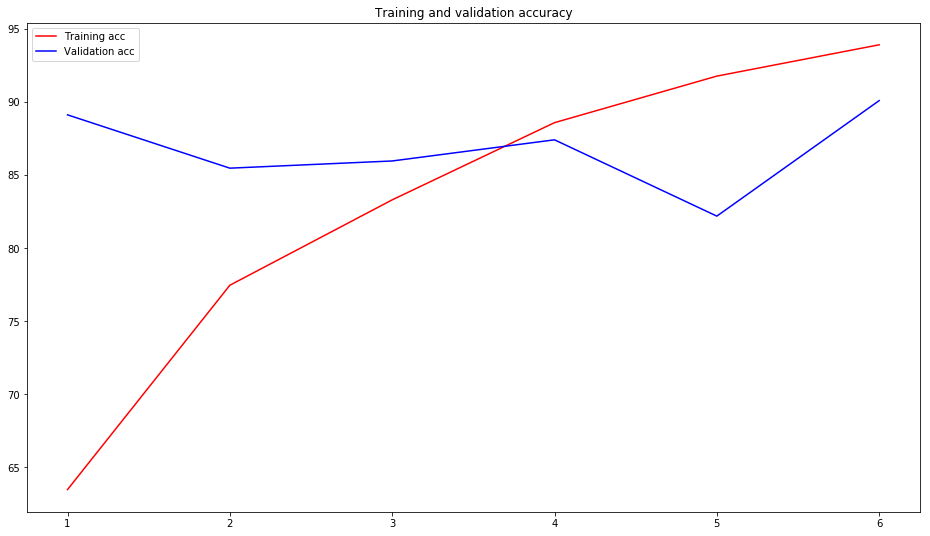

In [197]:
# Accuracy
epochs = range(1, EPOCH + 1)

plt.figure(figsize=(16, 9))
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

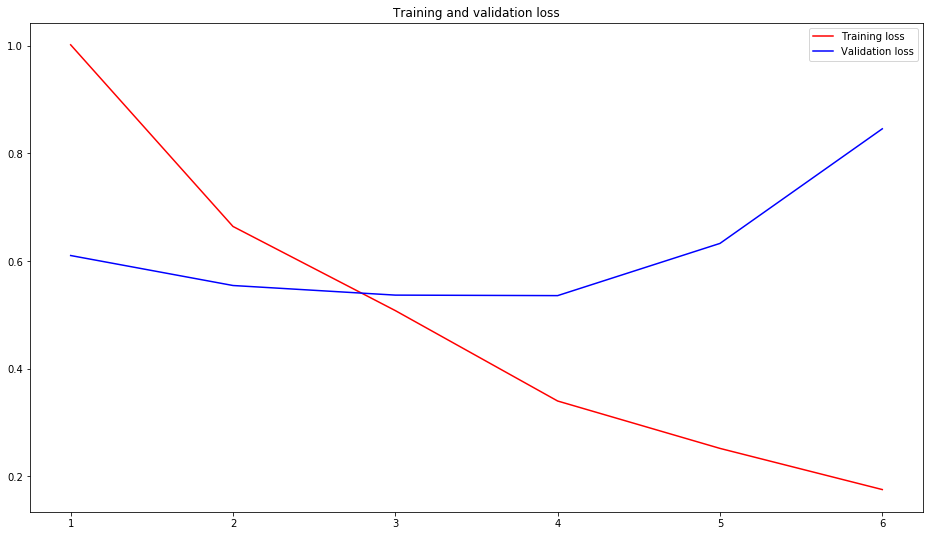

In [198]:
# Loss

plt.figure(figsize=(16, 9))
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evaluate on validation set

In [199]:
accuracy = 0

for test in val_data:
    pred = model(test[0], False).max(1)[1]
    pred = pred.data.tolist()[0]
    target = test[1].data.tolist()[0][0]
    if pred == target:
        accuracy += 1

print(accuracy/len(val_data) * 100)

90.15173480235818


### Make nice plots

In [200]:
if 'Y_VAL' in locals():
    del Y_VAL, Y_VAL_PREDS
    
for data in getBatch(50, val_data):
    inputs, targets = pad_to_batch(data)

    y_val_pred = model(inputs, False)
    preds = y_val_pred.max(1)[1]
    
    if 'Y_VAL' in locals():
        Y_VAL = torch.cat((Y_VAL, targets), 0)
        Y_VAL_PREDS = torch.cat((Y_VAL_PREDS, preds), 0)
    else:
        Y_VAL = targets
        Y_VAL_PREDS = preds

In [201]:
from sklearn.metrics import confusion_matrix

In [202]:
conf_mat = confusion_matrix(Y_VAL, Y_VAL_PREDS, labels = [0, 1, 2])

In [203]:
# funtion to plot confusion matrices, will be needed later

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else:
        print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)

    print(cm)
    
    
    plt.title(title)
    plt.colorbar( )
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.93904368 0.04489597 0.01606035]
 [0.27131783 0.61111111 0.11757106]
 [0.07163959 0.08050222 0.8478582 ]]


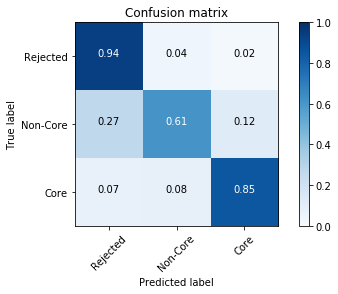

In [204]:
plt.figure()
plot_confusion_matrix(conf_mat, ['Rejected', 'Non-Core', 'Core'], normalize=True)
plt.show()